In [1]:
import sys
# print(sys.executable)

In [1]:
from collections import Counter
from dotenv import dotenv_values
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim import corpora, models, similarities
from gensim.models.ldamulticore import LdaMulticore
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
from langdetect import detect, DetectorFactory
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from langchain_community.llms import GPT4All
# from sklearn.metrics import confusion_matrix
import seaborn as sns
# from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
# from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import f1_score
# from sklearn.naive_bayes import MultinomialNB
from tqdm import tqdm
from wordcloud import WordCloud
import nest_asyncio
import praw
from sklearn.manifold import TSNE
import re
import string

nest_asyncio.apply()

nltk.download("vader_lexicon")
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\raize\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\raize\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\raize\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\raize\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')

Reddit is the server that provides an API (Application Programming Interface).
PRAW is a Python library that acts as the client, meaning it communicates with Reddit's API on your behalf.

In [9]:
#env file has all the hidden credentials
config = dotenv_values(".env")

#reddit API praw library to collect r/<insert movie here> posts 
reddit = praw.Reddit(
    client_id = config['CLIENT_ID'],
    client_secret = config['CLIENT_SECRET'], 
    user_agent = config['USER_AGENT'],
)

In [4]:
#Accesses the subreddit r/Inception using the Reddit API client (client: a piece of code or software that connects to a server to request or interact with data or services)
subreddit = reddit.subreddit("Inception")

In [5]:
DetectorFactory.seed = 0  # To make detection more consistent because the detect's random nature might give slightly different results

reviews = []
for submission in subreddit.new(limit=5000): # Adjust the limit as needed
    if submission.selftext:
        try:
            if detect(submission.selftext) == 'en':
                reviews.append(submission.selftext)
        except:
            pass  # Skip if language detection fails (e.g., very short text)

print('Collected:', len(reviews), 'Inception-related reviews/posts in english.')

Collected: 497 Inception-related reviews/posts in english.


In [6]:
inception = pd.DataFrame({'reviews':reviews})
inception.head(2)

,reviews
0,So I was thinking about the fact that dreams a...
1,How much of the dream is remembered by the dre...


In [7]:
vader = SentimentIntensityAnalyzer()

In [8]:
# inception['vader_score'] = inception['reviews'].apply(lambda x: vader.polarity_scores(x))
#add vader scores into the Inception dataframe
inception['positive_sentiment_score'] = inception['reviews'].apply(lambda x: vader.polarity_scores(x)['pos'])
inception['negative_sentiment_score'] = inception['reviews'].apply(lambda x: vader.polarity_scores(x)['neg'])
inception['neutral_sentiment_score'] = inception['reviews'].apply(lambda x: vader.polarity_scores(x)['neu'])
inception['compound_sentiment_score'] = inception['reviews'].apply(lambda x: vader.polarity_scores(x)['compound'])

In [9]:
inception.head()

,reviews,positive_sentiment_score,negative_sentiment_score,neutral_sentiment_score,compound_sentiment_score
0,So I was thinking about the fact that dreams a...,0.128,0.020,0.852,0.9178
1,How much of the dream is remembered by the dre...,0.094,0.034,0.872,0.8862
2,This post is purely for fun to spark discussio...,0.194,0.032,0.773,0.7564
3,"If he is still dreaming, soon or later he’ll w...",0.139,0.000,0.861,0.5647
4,"If, during the mission, projection-Mal insists...",0.029,0.116,0.855,-0.7319


In [10]:
inception.loc[inception['compound_sentiment_score'] >= .05, 'sentiment'] = 'positive'
inception.loc[inception['compound_sentiment_score'] <= -.05, 'sentiment'] = 'negative'
inception.loc[(inception['compound_sentiment_score'] > -.05) & (inception['compound_sentiment_score'] < .05), 'sentiment'] = 'neutral'

In [11]:
inception[inception['sentiment'] == 'neutral'][:4]

,reviews,positive_sentiment_score,negative_sentiment_score,neutral_sentiment_score,compound_sentiment_score,sentiment
22,"Do anyone know if this is cg or not, if not ho...",0.000,0.00,1.000,0.0000,neutral
25,"In *Inception*, Cobb returns to the initial st...",0.052,0.04,0.909,0.0395,neutral
41,Just watched the movie for the first time last...,0.000,0.00,1.000,0.0000,neutral
63,My favourite facial expression in the movie. T...,0.000,0.00,1.000,0.0000,neutral


In [12]:
# Classify overall sentiment as positive, negative, or neutral
def classify_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

inception['sentiment'] = inception['compound_sentiment_score'].apply(classify_sentiment)

In [13]:
inception[['reviews', 'compound_sentiment_score', 'sentiment']].head()

,reviews,compound_sentiment_score,sentiment
0,So I was thinking about the fact that dreams a...,0.9178,positive
1,How much of the dream is remembered by the dre...,0.8862,positive
2,This post is purely for fun to spark discussio...,0.7564,positive
3,"If he is still dreaming, soon or later he’ll w...",0.5647,positive
4,"If, during the mission, projection-Mal insists...",-0.7319,negative


In [14]:
#creating a stop words list - these words don't add much value
#adding additional words I don't find to be that valuable
additional_stopwords = ['https', 'I', 'com', 'http', 'RT', 'co', 'the', 'amp', 'the', 'lt', 'A', 'www', 'rt', 'got', 'get', 
                        'ly', 'u', 'also', 'like', 'could', 'get', 'go', 'know', 'org', 'edu', 'cdn', 'img', 'jpg', 'png', 
                        'even']
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += additional_stopwords
stopwords_list = list(set([word.lower() for word in stopwords_list])) #set just incase I add duplicates and need them removed, lower for consistency
print(stopwords_list)

['into', 'for', "i've", 'isn', 'weren', 'those', 'again', "didn't", "mightn't", 'don', 'go', 'under', 'during', '#', '%', 'com', 'also', 'having', 'he', 'herself', "they'd", 'than', 'until', '~', 'but', 'an', "shouldn't", 'yourselves', 'ours', 'and', "it'll", 'at', 'o', "we're", 'himself', '}', 'hadn', 'over', 'we', 'cdn', 'if', 'them', 'jpg', 'off', "doesn't", "you've", 'didn', 'each', 'his', 'down', 'who', 'below', 'such', "wasn't", 'too', 'like', 'once', 'up', 'only', '!', 'have', 'how', "she'll", "hadn't", "i'd", '[', "couldn't", "should've", 'get', 'shouldn', "they'll", 'ain', 'more', '`', 'between', 'our', 'ma', '@', 'wouldn', 'other', 'above', "we'll", 'edu', 'd', "aren't", 'did', "mustn't", 'doesn', "it's", 'll', "shan't", '>', 'should', 'png', 'be', 'in', 'hers', 'itself', 'https', '_', 'which', 'mightn', 'couldn', 'ourselves', 'all', "that'll", ',', "he's", 'theirs', '/', 'most', 'before', 'lt', "i'll", 'no', 'when', 'my', 'same', 'am', "i'm", 'further', 'where', 'him', 'thei

In [15]:
# inception.shape
inception.head(2)

,reviews,positive_sentiment_score,negative_sentiment_score,neutral_sentiment_score,compound_sentiment_score,sentiment
0,So I was thinking about the fact that dreams a...,0.128,0.020,0.852,0.9178,positive
1,How much of the dream is remembered by the dre...,0.094,0.034,0.872,0.8862,positive


In [16]:
# Tokenize (make each word is a token) and remove stopwords
inception["split_review"] = inception['reviews'].str.lower().str.split()
inception["filtered_review"] = inception["split_review"].apply(lambda tokens: [word for word in tokens if word not in stopwords_list]) #removes stopwords

In [17]:
all_words = inception["filtered_review"].explode()
# type(all_words)
# Use counter to count the frequency of words and get a dictionary then most common will return a tuple
# top_words = Counter(all_words).most_common(25)
# print(top_words)

# Create frequency distribution then retrieve top #
fdist = FreqDist(all_words)
# fdist.most_common(25)

## Function version

In [6]:
def analyze_subreddits_sentiment(reddit_client, subreddits, post_limit=5000):
    """
    Use this function to analyze sentiment and word frequency from multiple movie subreddits.
    
    Args:
        reddit_client: authenticated PRAW Reddit instance
        subreddits: list of subreddit names (strings)
        post_limit: max number of posts to fetch per subreddit (default 5000)
        
    Returns:
        dict of {subreddit_name: DataFrame} with reviews and sentiment info
    """
    
    DetectorFactory.seed = 0  # make language detection deterministic
    vader = SentimentIntensityAnalyzer()
    
    # Prepare stopwords list
    additional_stopwords = ['https', 'i', 'com', 'http', 'rt', 'co', 'the', 'amp', 'lt', 'a', 'www', 'got', 'get', 
                            'ly', 'u', 'also', 'like', 'could', 'go', 'know', 'org', 'edu', 'cdn', 'img', 'jpg', 'png', 'even']
    stopwords_list = stopwords.words('english')
    stopwords_list += list(string.punctuation)
    stopwords_list += additional_stopwords
    stopwords_list = list(set([word.lower() for word in stopwords_list]))
    
    def classify_sentiment(score):
        if score >= 0.05:
            return 'positive'
        elif score <= -0.05:
            return 'negative'
        else:
            return 'neutral'
    
    results = {}
    
    for subreddit_name in subreddits:
        subreddit = reddit_client.subreddit(subreddit_name)
        
        reviews = []
        for submission in subreddit.new(limit=post_limit):
            if submission.selftext:
                try:
                    if detect(submission.selftext) == 'en':
                        reviews.append(submission.selftext)
                except:
                    pass
        
        df = pd.DataFrame({'reviews': reviews})
        
        # Sentiment analysis with VADER
        df['positive_sentiment_score'] = df['reviews'].apply(lambda x: vader.polarity_scores(x)['pos'])
        df['negative_sentiment_score'] = df['reviews'].apply(lambda x: vader.polarity_scores(x)['neg'])
        df['neutral_sentiment_score'] = df['reviews'].apply(lambda x: vader.polarity_scores(x)['neu'])
        df['compound_sentiment_score'] = df['reviews'].apply(lambda x: vader.polarity_scores(x)['compound'])
        
        df['sentiment'] = df['compound_sentiment_score'].apply(classify_sentiment)
        
        # Tokenize and remove stopwords
        df["split_review"] = df['reviews'].str.lower().str.split()
        df["filtered_review"] = df["split_review"].apply(lambda tokens: [word for word in tokens if word not in stopwords_list])
        
        # Frequency distribution
        all_words = df["filtered_review"].explode()
        fdist = FreqDist(all_words)
        
        # Store both dataframe and frequency distribution
        results[subreddit_name] = {'dataframe': df, 'freq_dist': fdist}
        
    return results

In [11]:
# Assuming you have an authenticated PRAW Reddit client called `reddit`
movie_subreddits = ['Inception', 'Wicked'] #'A Walk To Remember'

result = analyze_subreddits_sentiment(reddit, movie_subreddits, post_limit=1000)

# Access dataframe for 'Inception'
inception_df = result['Inception']['dataframe']
inception_freq_dist = result['Inception']['freq_dist']

inception_df.head()
# print(inception_freq_dist.most_common(20))

,reviews,positive_sentiment_score,negative_sentiment_score,neutral_sentiment_score,compound_sentiment_score,sentiment,split_review,filtered_review
0,So I was thinking about the fact that dreams a...,0.128,0.020,0.852,0.9178,positive,"[so, i, was, thinking, about, the, fact, that,...","[thinking, fact, dreams, lot, less, consistent..."
1,How much of the dream is remembered by the dre...,0.094,0.034,0.872,0.8862,positive,"[how, much, of, the, dream, is, remembered, by...","[much, dream, remembered, dreamers?, fischer, ..."
2,This post is purely for fun to spark discussio...,0.194,0.032,0.773,0.7564,positive,"[this, post, is, purely, for, fun, to, spark, ...","[post, purely, fun, spark, discussion., posing..."
3,"If he is still dreaming, soon or later he’ll w...",0.139,0.000,0.861,0.5647,positive,"[if, he, is, still, dreaming,, soon, or, later...","[still, dreaming,, soon, later, he’ll, wake, p..."
4,"If, during the mission, projection-Mal insists...",0.029,0.116,0.855,-0.7319,negative,"[if,, during, the, mission,, projection-mal, i...","[if,, mission,, projection-mal, insists, cobb,..."


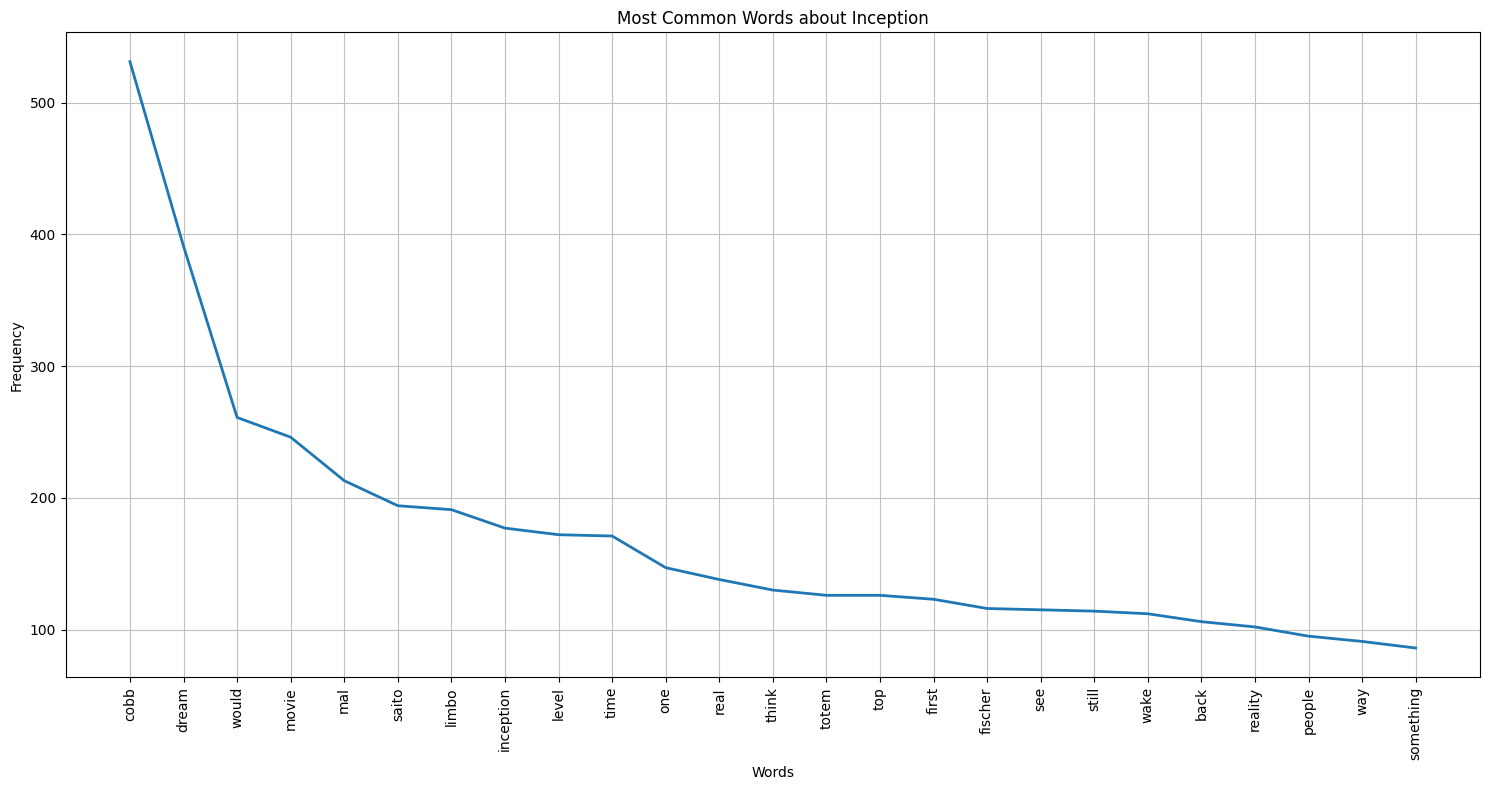

In [15]:
#line plot
fig, ax = plt.subplots(1,1, figsize=(15,8)) 
ax = fdist.plot(25, title="Most Common Words about Inception") #the num is the amount of common words
ax.set_xlabel("Words")
ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

# plt.savefig('images/inceptionfrequency.jpg')

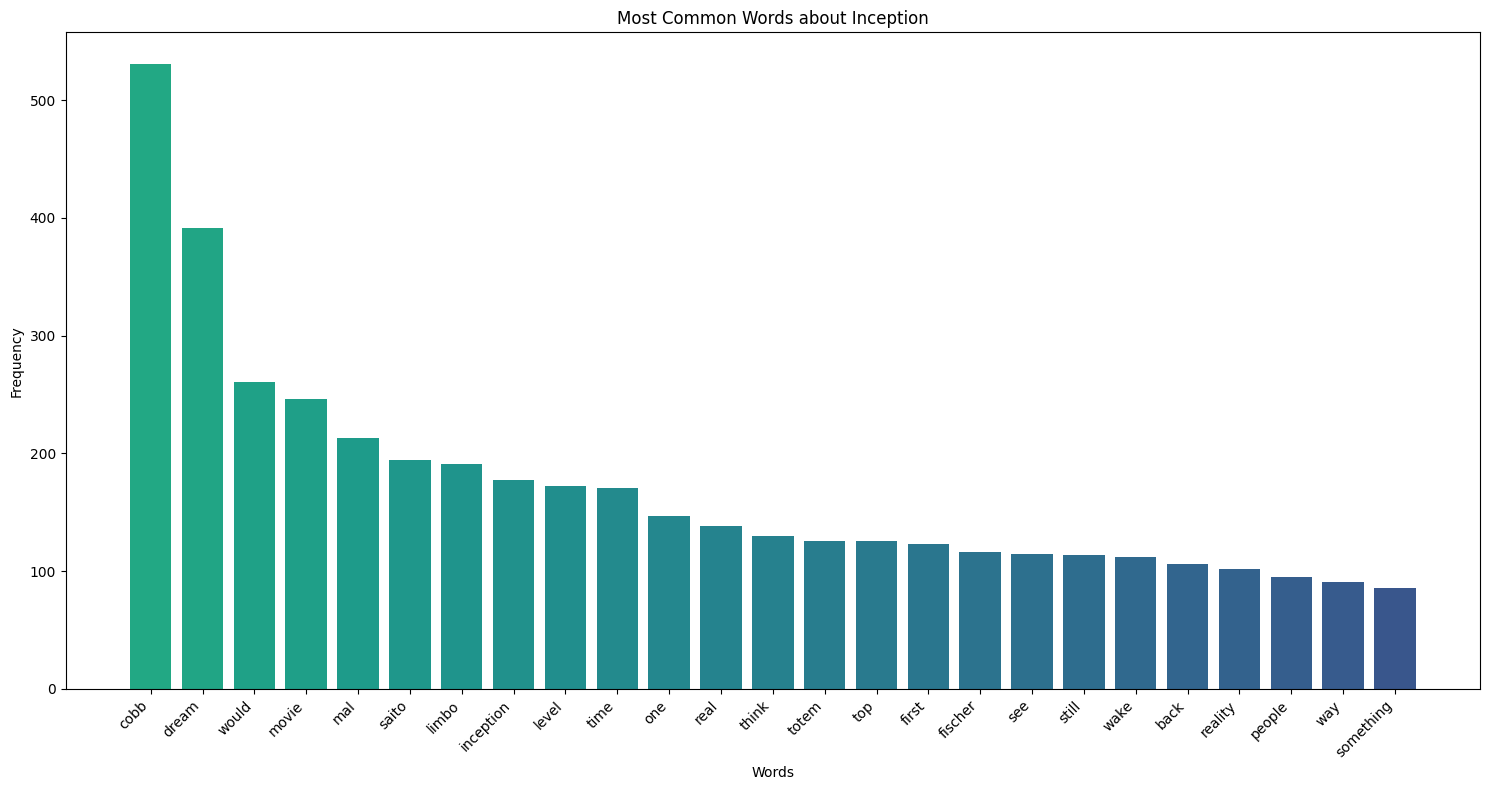

In [17]:
# Split words and counts for plotting
top_words = Counter(all_words).most_common(25)
words, counts = zip(*top_words)

fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(words, counts, color=cm.viridis_r(np.linspace(.4,.8, 30)))
ax.set_title("Most Common Words about Inception")
ax.set_xlabel("Words")
ax.set_ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# plt.savefig('images/barInceptionFrequency.png')

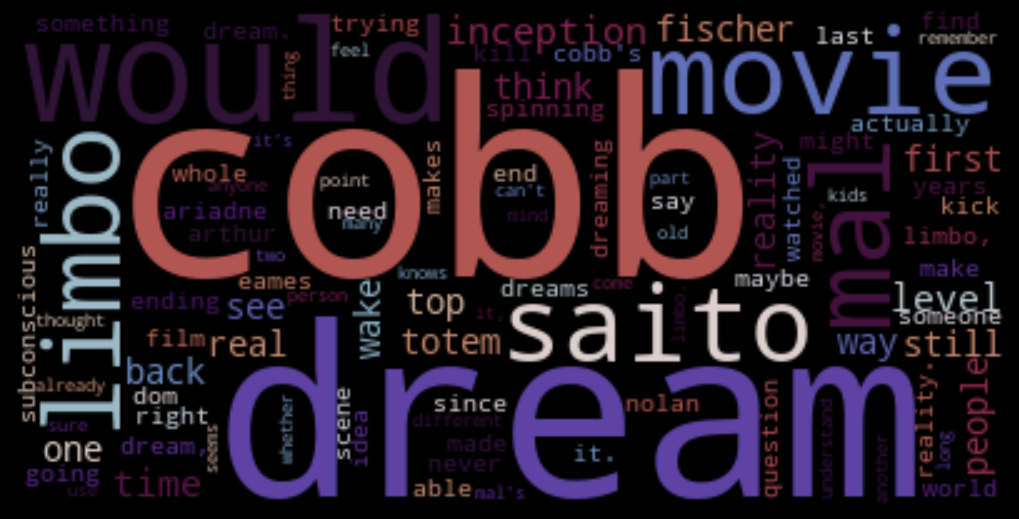

In [18]:
# Create frequency distribution from most common
top_100_dict = dict(fdist.most_common(100))

# Create the word cloud:
wordcloud = WordCloud(colormap='twilight_shifted').generate_from_frequencies(top_100_dict)

# Display the generated image w/ matplotlib:
plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

# Uncomment the next line if you want to save your image:
# plt.savefig('images/inceptionwordcloud.jpg')

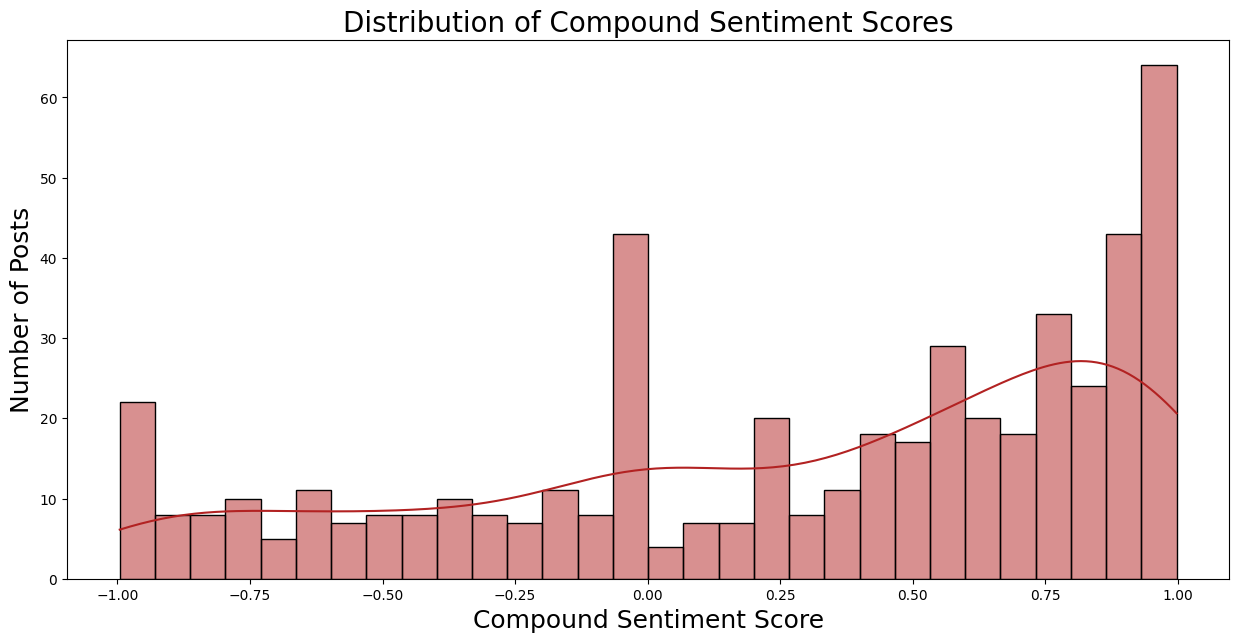

In [19]:
# Plot the distribution
plt.figure(figsize=(15,7))
sns.histplot(inception['compound_sentiment_score'].dropna(), color='firebrick', bins=30, kde=True)
plt.xlabel('Compound Sentiment Score', fontsize=18)
plt.ylabel('Number of Posts', fontsize=18)
plt.title('Distribution of Compound Sentiment Scores', fontsize=20)
plt.show()

# plt.savefig('Reddit_NLP_Sentiment/images/VADERinception.jpg')

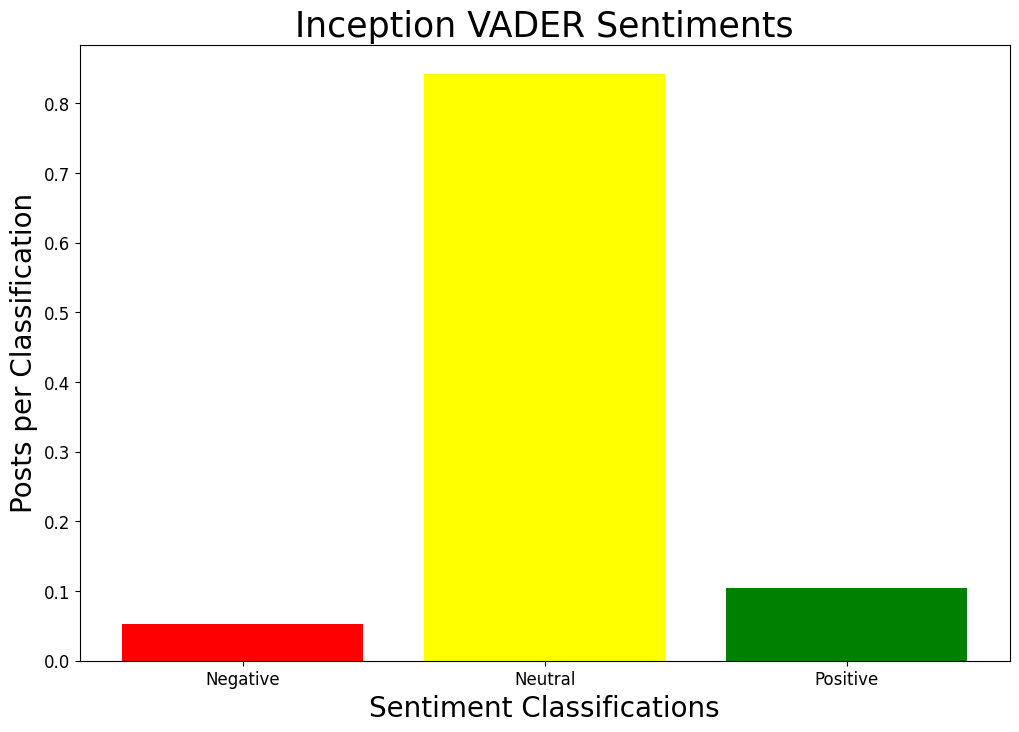

In [20]:
#bar plot representation of negative, neutral, and positive vader scores

avg_scores = {
    'Negative': inception['negative_sentiment_score'].mean(),
    'Neutral': inception['neutral_sentiment_score'].mean(),
    'Positive': inception['positive_sentiment_score'].mean()
}

fig, ax = plt.subplots(figsize=(12,8))
ax.bar(avg_scores.keys(), avg_scores.values(), color =['red', 'yellow', 'green'])
plt.title('Inception VADER Sentiments', fontsize=25)
plt.xlabel('Sentiment Classifications', fontsize=20)
plt.ylabel('Posts per Classification', fontsize=20)
plt.tick_params(labelsize='large')

# plt.savefig('images/inceptionsentiments.jpg')

## LDA & TSNE

In [21]:
#stemmed tweets
ps = PorterStemmer()

In [71]:
inception.head(2)
# all_words[:4]

,reviews,positive_sentiment_score,negative_sentiment_score,neutral_sentiment_score,compound_sentiment_score,sentiment,split_review,filtered_review,stemmed_review
0,This post is purely for fun to spark discussio...,0.194,0.032,0.773,0.7564,positive,"[this, post, is, purely, for, fun, to, spark, ...","[post, purely, fun, spark, discussion., posing...","[post, pure, fun, spark, discussion., pose, se..."
1,"If he is still dreaming, soon or later he’ll w...",0.139,0.000,0.861,0.5647,positive,"[if, he, is, still, dreaming,, soon, or, later...","[still, dreaming,, soon, later, he’ll, wake, p...","[still, dreaming,, soon, later, he’ll, wake, p..."


In [18]:
# Apply stemming to each word in all_words
# inception["stemmed_review"] = inception["filtered_review"].apply(lambda tokens: [ps.stem(word) for word in tokens])

inception["stemmed_review"] = inception["filtered_review"].apply(
    lambda tokens: [ps.stem(re.sub(f"[{re.escape(string.punctuation)}]", "", word)) for word in tokens if re.sub(f"[{re.escape(string.punctuation)}]", "", word)]
)

NameError: name 'ps' is not defined

In [ ]:
# Assuming your DataFrame is called df
inception['stemmed_review_nolst'] = inception['stemmed_review'].apply(lambda x: ' '.join(x))

In [ ]:
inception.head(3)

In [ ]:
# Join stemmed words per document into a single string
stemmed_words = inception["stemmed_review"].apply(lambda tokens: " ".join(tokens))

# Vectorize
vec = CountVectorizer(stop_words=list(stopwords_list))
X = vec.fit_transform(stemmed_words)

# Create DataFrame from the DTM
df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out())

print(df.shape)
df.head()

In [ ]:
#dictionary of numbers to words
dictionary = corpora.Dictionary(inception["stemmed_review"])
type(dictionary)
len(dictionary)

In [ ]:
dictionary[1]

In [ ]:
#bag of words (tokenid, tokencount)
corpus = [dictionary.doc2bow(d) for d in inception['stemmed_review']]

In [53]:
# corpus[:1]

In [ ]:
#running LDA model
lda = models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=5, passes=10)
lda.print_topics()

In [29]:
#clarifying LDA model
topics_data = []
for elem in lda.print_topics(-1):
    print("Topic", elem[0], "\nWords:", elem[1])
    topics_data.append([elem[0], elem[1]])

topics_df = pd.DataFrame(topics_data, columns=['Topic Number', 'Words'])

Topic 0 
Words: 0.042*"dream" + 0.011*"real" + 0.011*"cobb" + 0.010*"peopl" + 0.010*"wake" + 0.008*"realiti" + 0.007*"movi" + 0.007*"limbo" + 0.006*"machin" + 0.006*"one"
Topic 1 
Words: 0.027*"dream" + 0.009*"totem" + 0.009*"movi" + 0.007*"incept" + 0.006*"use" + 0.006*"would" + 0.005*"drug" + 0.005*"see" + 0.005*"one" + 0.005*"make"
Topic 2 
Words: 0.017*"incept" + 0.016*"movi" + 0.016*"fischer" + 0.010*"dream" + 0.008*"one" + 0.008*"time" + 0.008*"father" + 0.007*"think" + 0.007*"cobb" + 0.007*"charact"
Topic 3 
Words: 0.033*"cobb" + 0.028*"dream" + 0.012*"saito" + 0.010*"movi" + 0.008*"mal" + 0.008*"think" + 0.007*"incept" + 0.007*"limbo" + 0.006*"would" + 0.006*"time"
Topic 4 
Words: 0.025*"cobb" + 0.022*"dream" + 0.016*"limbo" + 0.014*"mal" + 0.012*"level" + 0.011*"would" + 0.010*"time" + 0.010*"saito" + 0.009*"movi" + 0.009*"realiti"


In [ ]:
pd.set_option('display.max_colwidth', None)
display(topics_df)

In [62]:
# Display model
pyLDAvis.enable_notebook()

vis = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis)  # if you're in Jupyter Notebook

In [67]:
vis
pyLDAvis.save_html(vis, 'lda_visualization.html')

In [5]:
# from gpt4all import GPT4All
# model = GPT4All("Meta-Llama-3-8B-Instruct.Q4_0.gguf") # downloads / loads a 4.66GB LLM
# with model.chat_session():
#     print(model.generate("How can I run LLMs efficiently on my laptop?", max_tokens=1024))

In [2]:
# from langchain_community.llms import GPT4All

# model_path = "/Users/r/models/ggml-gpt4all-j-v1.3-groovy.bin"  # Replace with actual path

# llm = GPT4All(model=model_path, backend="gptj", verbose=True)

# response = llm("Summarize the main themes of the movie Inception.")
# print(response)

In [3]:
# from transformers import AutoModelForCausalLM

# model = AutoModelForCausalLM.from_pretrained("nomic-ai/gpt4all-j", revision="v1.2-jazzy")

In [4]:
# from langchain_community.llms import GPT4All

# # Path to the downloaded model (.bin file)
# model_path = "/Users/r/llama-2-7b-chat.ggmlv3.q4_0-001.bin"

# # Create the LLM
# llm = GPT4All(model=model_path, backend="llama", verbose=True)

# # Run a simple prompt
# response = llm("Summarize the main themes of the movie Inception.")
# print(response)

In [ ]:
prompt = """
Here are 5 topics from an LDA model on Reddit posts about the movie *Inception*.
Each topic contains its top words. Give each topic a short descriptive label.

Topic 0: dream, reality, subconscious, mind, layers  
Topic 1: movie, nolan, director, plot, brilliant  
Topic 2: cobb, mal, arthur, dom, wife  
Topic 3: time, loop, ending, confusing, paradox  
Topic 4: music, zimmer, soundtrack, score, theme  
"""

response = llm(prompt)
print(response)

# T-SNE

In [63]:
print(range(len(corpus)))
#LDA matrix results
X = []
for i in range(len(corpus)):
    if len(lda[corpus[i]]) == 5:
        X.append([y for (x,y) in lda[corpus[i]]])       
# X

range(0, 308)


In [64]:
#reduce dimensionality
tsne = TSNE(n_components=2, random_state=27)
embedding = tsne.fit_transform(np.array(X))
embedding = pd.DataFrame(embedding, columns=['x','y'])
embedding['hue'] = np.array(X).argmax(axis=1)

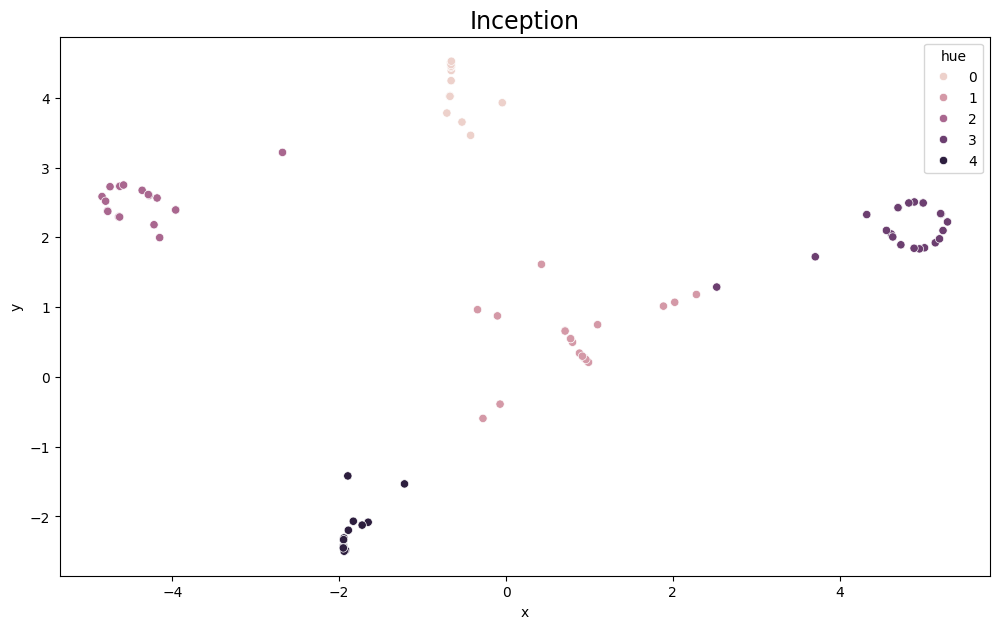

In [65]:
# plot of reduced dimensionality for Inception
fig, ax = plt.subplots(figsize =(12,7))
sns.scatterplot(
    x = "x", y="y",
    hue="hue",
    ax = ax,
    data=embedding)
plt.title('Inception', fontsize = 17)
plt.savefig('images/tsne_inception.jpg')